#### Importing modules

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy
from pathlib import Path
from os.path import join as pjoin
from scipy.stats import mode

import matplotlib.pyplot as plt

import chiCa.chiCa as chiCa
from chiCa.chiCa.visualization_utils import separate_axes
# from spks.sync import load_ni_sync_data,interp1d
# from spks.event_aligned import compute_firing_rate
# from spks.clusters import Clusters
import spks

from utils import *
from viz import *


%matplotlib widget

#### Loading nidaq and behavior data

In [ ]:
def load_sync_data(sessionpath, sync_port=0):
    """Load and process sync data from nidaq and probe"""
    print('Loading nisync data...')
    (nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = spks.sync.load_ni_sync_data(sessionpath=sessionpath)
    aponsets = apsyncdata[0]['file0_sync_onsets'][6]

    corrected_onsets = {}
    corrected_offsets = {}
    for k in nionsets.keys():
        corrected_onsets[k] = spks.sync.interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')
        corrected_offsets[k] = spks.sync.interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nioffsets[k]).astype('uint64')
    del k

    nitime = spks.sync.interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))
    srate = apsyncdata[0]['sampling_rate']
    t = nitime/srate
    frame_rate = mode(1/(np.diff(corrected_onsets[1])/srate))
    analog_signal = nisync[:, 0]
    print('Success!\n-----')
    
    return corrected_onsets, corrected_offsets, t, srate, analog_signal

def process_port_events(corrected_onsets, corrected_offsets, srate):
    """Process port entry/exit events if they exist"""
    print('Loading nidaq events...')
    trial_starts = corrected_onsets[2]/srate
    
    if len(corrected_onsets.keys()) <= 3:
        print('No port events registered in this session. Proceeding without them...')
        return trial_starts, None
        
    print('Port events found. Proceeding with extracting them...')
    port_events = {
        "center_port": {
            "entries": corrected_onsets[4]/srate,
            "exits": corrected_offsets[4]/srate
        },
        "left_port": {
            "entries": corrected_onsets[3]/srate,
            "exits": corrected_offsets[3]/srate
        },
        "right_port": {
            "entries": corrected_onsets[5]/srate,
            "exits": corrected_offsets[5]/srate
        }
    }
    
    return trial_starts, port_events

def process_trial_data(sessionpath, trial_starts, t, srate, analog_signal, port_events, animal, session):
    """Process trial data and timestamps"""
    behavior_data = chiCa.load_trialdata(pjoin(sessionpath, f'chipmunk/{animal}_{session}_chipmunk_DemonstratorAudiTask.mat'))
    
    if port_events is None:
        trial_ts = get_trial_ts(trial_starts, detect_stim_events(t, srate, analog_signal, amp_threshold=5000), behavior_data)
    else:
        trial_ts = get_trial_ts(trial_starts, detect_stim_events(t, srate, analog_signal, amp_threshold=5000), behavior_data, port_events)
        trial_ts.insert(trial_ts.shape[1], 'response', trial_ts.apply(get_response_ts, axis=1))
        
    trial_ts.insert(trial_ts.shape[1], 'stationary_stims', trial_ts.apply(get_stationary_stims, axis=1))
    trial_ts.insert(trial_ts.shape[1], 'movement_stims', trial_ts.apply(get_movement_stims, axis=1))
    print('Success!')
    return trial_ts

# Main execution
animal = 'GRB006'
session = '20240723_142451'
sessionpath = Path(f'/Volumes/T7/{session}')

corrected_onsets, corrected_offsets, t, srate, analog_signal = load_sync_data(sessionpath)
trial_starts, port_events = process_port_events(corrected_onsets, corrected_offsets, srate)
trial_ts = process_trial_data(sessionpath, trial_starts, t, srate, analog_signal, port_events, animal, session)

#### Loading and filtering KS results

In [ ]:
kilosort_path = Path(f'{sessionpath}/kilosort2.5/imec0/')
sc = np.load(pjoin(kilosort_path, 'spike_clusters.npy')) #KS clusters
ss = np.load(pjoin(kilosort_path, 'spike_times.npy')) #KS spikes (in samples)
st = ss/srate #conversion from spike samples to spike times

clu =  spks.clusters.Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

good_units_mask, n_units = get_good_units(clusters_obj = clu, spike_clusters = sc)
print(f'# good units: {n_units}')

In [69]:
first_stim_ts = np.array(trial_ts[trial_ts.trial_outcome != -1].first_stim_ts).flatten()

# Convert list of arrays into a single flattened array
# All stims
movement_stims = np.hstack(trial_ts[trial_ts.trial_outcome != -1].movement_stims)
stationary_stims = np.hstack(trial_ts[trial_ts.trial_outcome != -1].stationary_stims)

# First stim of each type per trial
first_movement_stims = np.array([stims[0] if len(stims) > 0 else np.nan for stims in trial_ts[trial_ts.trial_outcome != -1].movement_stims])
first_stationary_stims = np.array([stims[0] if len(stims) > 0 else np.nan for stims in trial_ts[trial_ts.trial_outcome != -1].stationary_stims])

spike_times_per_unit = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_unit_ids = good_units_mask)

In [80]:
pop_peth, timebin_edges, event_index = spks.event_aligned.population_peth(all_spike_times = spike_times_per_unit, alignment_times = first_stim_ts, pre_seconds=0.15, post_seconds=0.5, binwidth_ms=25, pad=0, kernel=None)

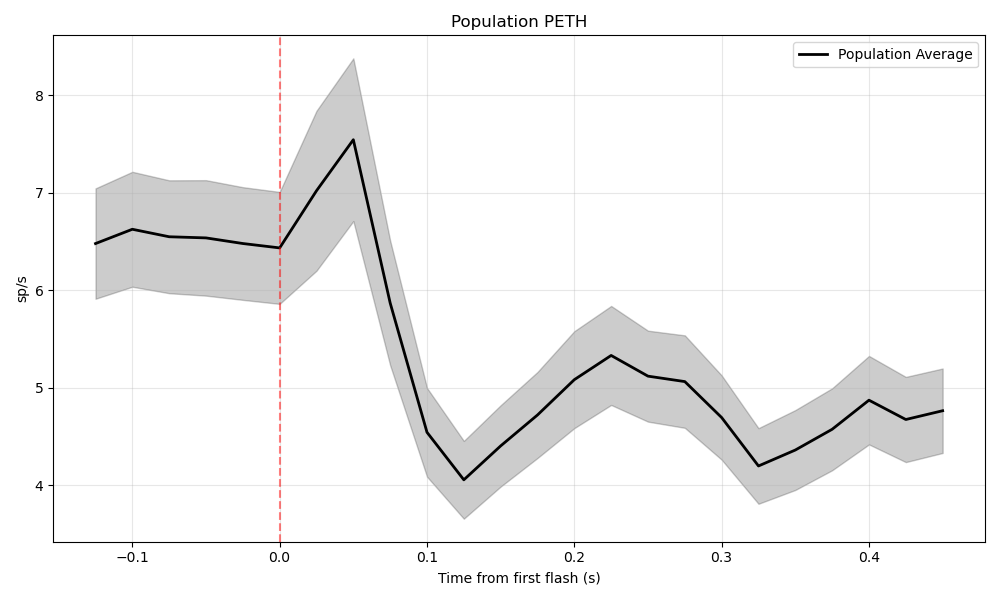

In [82]:
# Plot population PETH
fig, ax = plt.subplots(figsize=(10, 6))

# Raw PSTH plot
mean_peth = np.mean(pop_peth, axis=1) # Average across trials for each neuron
sem_peth = np.std(pop_peth, axis=1) / np.sqrt(pop_peth.shape[1]) # Calculate SEM

pop_mean = np.mean(mean_peth, axis=0)
pop_sem = np.std(mean_peth, axis=0) / np.sqrt(mean_peth.shape[0])
ax.plot(timebin_edges[:-1], pop_mean, color='black', linewidth=2, label='Population Average')
ax.fill_between(timebin_edges[:-1], pop_mean-pop_sem, pop_mean+pop_sem, color='black', alpha=0.2)

ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Time from first flash (s)')
ax.set_ylabel('sp/s')
ax.set_title('Population PETH')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()


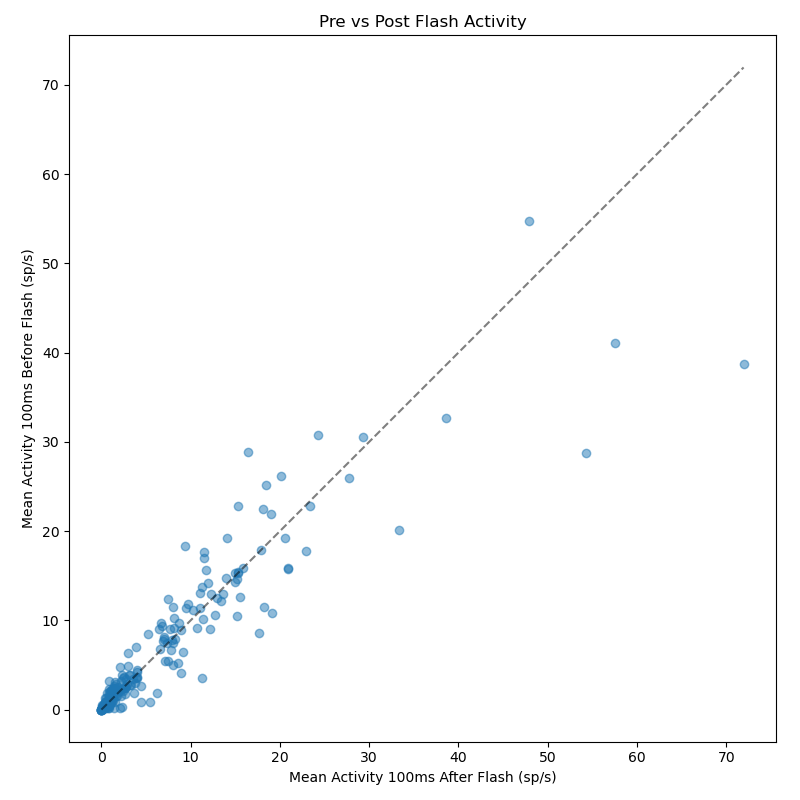

In [83]:
# Calculate mean activity in 100ms windows before and after flash
pre_window = (timebin_edges[:-1] >= -0.1) & (timebin_edges[:-1] < 0)
post_window = (timebin_edges[:-1] >= 0) & (timebin_edges[:-1] < 0.1)

pre_activity = np.mean(mean_peth[:, pre_window], axis=1)
post_activity = np.mean(mean_peth[:, post_window], axis=1)

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(post_activity, pre_activity, alpha=0.5)

# Add unity line
min_val = min(np.min(pre_activity), np.min(post_activity))
max_val = max(np.max(pre_activity), np.max(post_activity))
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

ax.set_xlabel('Mean Activity 100ms After Flash (sp/s)')
ax.set_ylabel('Mean Activity 100ms Before Flash (sp/s)')
ax.set_title('Pre vs Post Flash Activity')

# Make axes equal for better visualization
ax.set_aspect('equal')
plt.tight_layout()


Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from input array
Discarding 28 NaNs from inpu

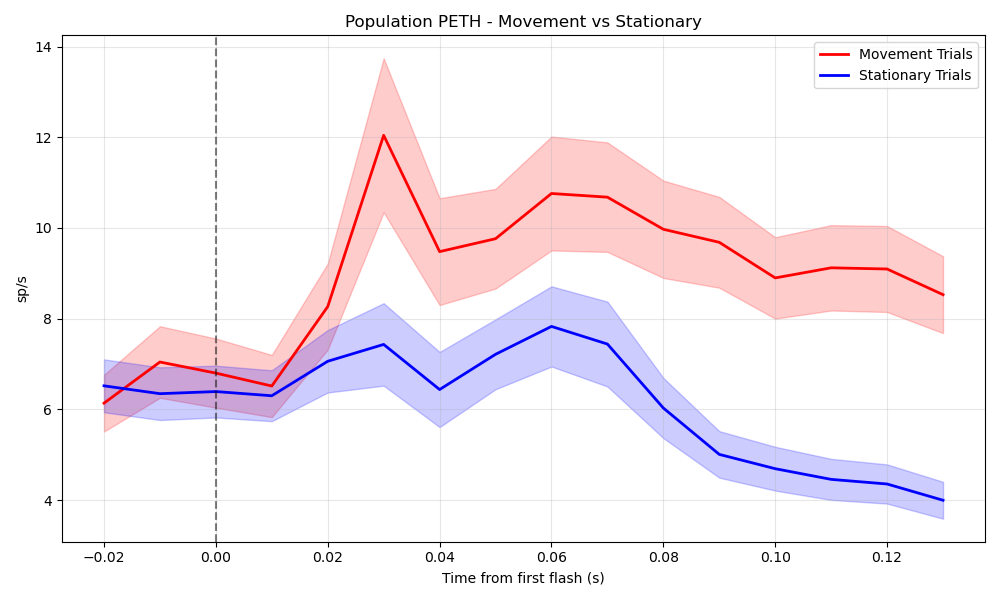

In [88]:
# Get PETHs for movement and stationary stimuli
pop_peth_move, timebin_edges_move, event_index_move = spks.event_aligned.population_peth(
    all_spike_times=spike_times_per_unit, 
    alignment_times=first_movement_stims,
    pre_seconds=0.025, 
    post_seconds=0.15, 
    binwidth_ms=10, 
    pad=0, 
    kernel=None
)

pop_peth_stat, timebin_edges_stat, event_index_stat = spks.event_aligned.population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=first_stationary_stims, 
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None
)

# Plot population PETH for both conditions
fig, ax = plt.subplots(figsize=(10, 6))

# Movement trials
mean_peth_move = np.mean(pop_peth_move, axis=1)
sem_peth_move = np.std(pop_peth_move, axis=1) / np.sqrt(pop_peth_move.shape[1])
pop_mean_move = np.mean(mean_peth_move, axis=0)
pop_sem_move = np.std(mean_peth_move, axis=0) / np.sqrt(mean_peth_move.shape[0])
ax.plot(timebin_edges_move[:-1], pop_mean_move, color='red', linewidth=2, label='Movement Trials')
ax.fill_between(timebin_edges_move[:-1], pop_mean_move-pop_sem_move, pop_mean_move+pop_sem_move, color='red', alpha=0.2)

# Stationary trials  
mean_peth_stat = np.mean(pop_peth_stat, axis=1)
sem_peth_stat = np.std(pop_peth_stat, axis=1) / np.sqrt(pop_peth_stat.shape[1])
pop_mean_stat = np.mean(mean_peth_stat, axis=0)
pop_sem_stat = np.std(mean_peth_stat, axis=0) / np.sqrt(mean_peth_stat.shape[0])
ax.plot(timebin_edges_stat[:-1], pop_mean_stat, color='blue', linewidth=2, label='Stationary Trials')
ax.fill_between(timebin_edges_stat[:-1], pop_mean_stat-pop_sem_stat, pop_mean_stat+pop_sem_stat, color='blue', alpha=0.2)

ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Time from first flash (s)')
ax.set_ylabel('sp/s')
ax.set_title('Population PETH - Movement vs Stationary')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()


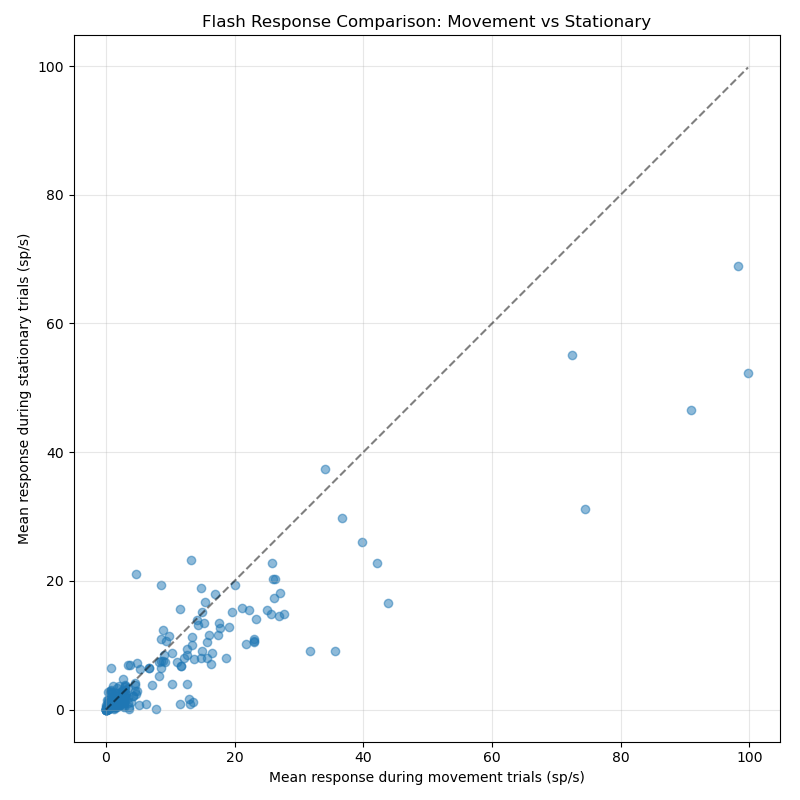

In [87]:
# Calculate mean activity in 100ms window after flash for both conditions
flash_window = (timebin_edges_move[:-1] >= 0) & (timebin_edges_move[:-1] <= 0.1)
move_flash_response = np.mean(mean_peth_move[:, flash_window], axis=1)
stat_flash_response = np.mean(mean_peth_stat[:, flash_window], axis=1)

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(move_flash_response, stat_flash_response, alpha=0.5)

# Add unity line
max_val = max(np.max(move_flash_response), np.max(stat_flash_response))
min_val = min(np.min(move_flash_response), np.min(stat_flash_response))
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Labels and title
ax.set_xlabel('Mean response during movement trials (sp/s)')
ax.set_ylabel('Mean response during stationary trials (sp/s)')
ax.set_title('Flash Response Comparison: Movement vs Stationary')

# Make axes equal
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()


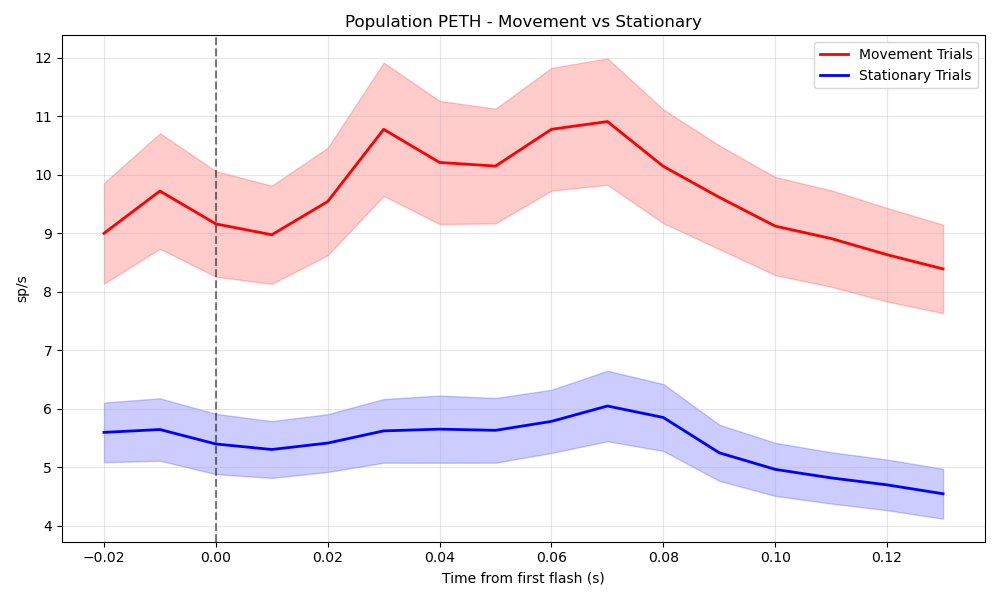

In [89]:
# Get PETHs for movement and stationary stimuli
pop_peth_move, timebin_edges_move, event_index_move = spks.event_aligned.population_peth(
    all_spike_times=spike_times_per_unit, 
    alignment_times=movement_stims,
    pre_seconds=0.025, 
    post_seconds=0.15, 
    binwidth_ms=10, 
    pad=0, 
    kernel=None
)

pop_peth_stat, timebin_edges_stat, event_index_stat = spks.event_aligned.population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=stationary_stims, 
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None
)

# Plot population PETH for both conditions
fig, ax = plt.subplots(figsize=(10, 6))

# Movement trials
mean_peth_move = np.mean(pop_peth_move, axis=1)
sem_peth_move = np.std(pop_peth_move, axis=1) / np.sqrt(pop_peth_move.shape[1])
pop_mean_move = np.mean(mean_peth_move, axis=0)
pop_sem_move = np.std(mean_peth_move, axis=0) / np.sqrt(mean_peth_move.shape[0])
ax.plot(timebin_edges_move[:-1], pop_mean_move, color='red', linewidth=2, label='Movement Trials')
ax.fill_between(timebin_edges_move[:-1], pop_mean_move-pop_sem_move, pop_mean_move+pop_sem_move, color='red', alpha=0.2)

# Stationary trials  
mean_peth_stat = np.mean(pop_peth_stat, axis=1)
sem_peth_stat = np.std(pop_peth_stat, axis=1) / np.sqrt(pop_peth_stat.shape[1])
pop_mean_stat = np.mean(mean_peth_stat, axis=0)
pop_sem_stat = np.std(mean_peth_stat, axis=0) / np.sqrt(mean_peth_stat.shape[0])
ax.plot(timebin_edges_stat[:-1], pop_mean_stat, color='blue', linewidth=2, label='Stationary Trials')
ax.fill_between(timebin_edges_stat[:-1], pop_mean_stat-pop_sem_stat, pop_mean_stat+pop_sem_stat, color='blue', alpha=0.2)

ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Time from first flash (s)')
ax.set_ylabel('sp/s')
ax.set_title('Population PETH - Movement vs Stationary')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

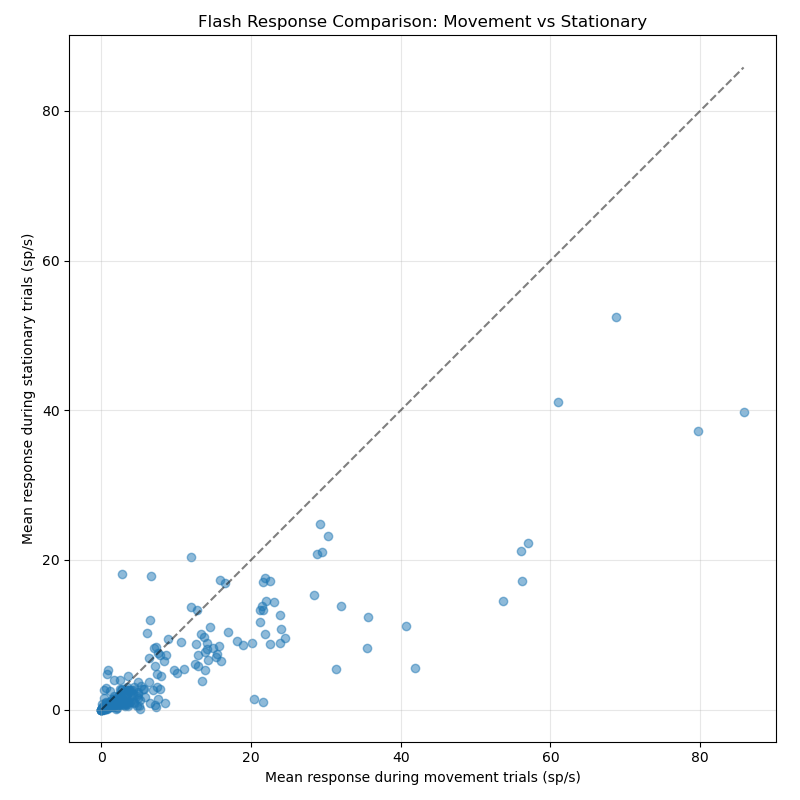

In [90]:
# Calculate mean activity in 100ms window after flash for both conditions
flash_window = (timebin_edges_move[:-1] >= 0) & (timebin_edges_move[:-1] <= 0.1)
move_flash_response = np.mean(mean_peth_move[:, flash_window], axis=1)
stat_flash_response = np.mean(mean_peth_stat[:, flash_window], axis=1)

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(move_flash_response, stat_flash_response, alpha=0.5)

# Add unity line
max_val = max(np.max(move_flash_response), np.max(stat_flash_response))
min_val = min(np.min(move_flash_response), np.min(stat_flash_response))
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Labels and title
ax.set_xlabel('Mean response during movement trials (sp/s)')
ax.set_ylabel('Mean response during stationary trials (sp/s)')
ax.set_title('Flash Response Comparison: Movement vs Stationary')

# Make axes equal
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()

In [27]:
def bootstrap_func(data, func, size = 10, folds = 10, bootstrap_mean_axis = None, **kwargs):
    res = []
    idx = np.arange(len(data))
    for _ in range(folds):
        ii = np.random.choice(idx, size = size,replace = True)
        sample = data[ii]
        res.append(func(data,**kwargs))
    if bootstrap_mean_axis is None:
        return np.nanmean(res)
    else:
        return np.nanmean(res,axis = bootstrap_mean_axis)

In [ ]:
#Get p-values for each cell's response during the trial periods compared to during the iti
from scipy.stats import mannwhitneyu
from tqdm import tqdm
def get_response_pvalue(traces, tasklog, sampleoffsets, dtype):
    
    key = dict(dtype = dtype)
    
    rewarded_traces = index_trig_traces_for_conditions(tasklog.rewarded == 1,traces)

    stimidx = np.arange(sampleoffsets[1], sampleoffsets[2])
    delayidx = np.arange(sampleoffsets[2], sampleoffsets[3])
    choiceidx = np.arange(sampleoffsets[3], sampleoffsets[4])
    postrwdidx = np.arange(sampleoffsets[4], sampleoffsets[5])

    bidx = np.arange(sampleoffsets[0], sampleoffsets[1])
    
    ridx1 = stimidx
    ridx2 = delayidx
    ridx3 = choiceidx
    ridx4 = postrwdidx
    
    print('computing {dtype} p-values...'.format(**key), flush = True)
    
    stim_pval = []
    delay_pval = []
    choice_pval = []
    postreward_pval = []
    for cell in tqdm(rewarded_traces):
        
        func1 = lambda y: mannwhitneyu(y[:,bidx].flatten()[np.where(np.isnan(y[:,bidx].flatten()) == False)[0]],
                                      y[:,ridx1].flatten()[np.where(np.isnan(y[:,ridx1].flatten()) == False)[0]]).pvalue
        func2 = lambda y: mannwhitneyu(y[:,bidx].flatten()[np.where(np.isnan(y[:,bidx].flatten()) == False)[0]],
                                      y[:,ridx2].flatten()[np.where(np.isnan(y[:,ridx2].flatten()) == False)[0]]).pvalue
        func3 = lambda y: mannwhitneyu(y[:,bidx].flatten()[np.where(np.isnan(y[:,bidx].flatten()) == False)[0]],
                                      y[:,ridx3].flatten()[np.where(np.isnan(y[:,ridx3].flatten()) == False)[0]]).pvalue
        func4 = lambda y: mannwhitneyu(y[:,bidx].flatten()[np.where(np.isnan(y[:,bidx].flatten()) == False)[0]],
                                      y[:,ridx4].flatten()[np.where(np.isnan(y[:,ridx4].flatten()) == False)[0]]).pvalue
        
        stim_pval.append(bootstrap_func(cell, func1, size = 8))
        choice_pval.append(bootstrap_func(cell, func3, size = 8))
        postreward_pval.append(bootstrap_func(cell, func4, size = 8))
        
        if not len(delayidx):
            delay_pval.append(None)
            continue
        else:
            delay_pval.append(bootstrap_func(cell,func2,size = 8))
            
    pvalues = [stim_pval, delay_pval, choice_pval, postreward_pval]
    
    return pvalues

In [ ]:
def analyze_stim_responses(
    spike_times, spike_clusters, good_units_mask, event_times, pre_window=0.05, post_window=0.05, alpha=0.05
):
    # Get the actual unit IDs from spike clusters, filtered by good units
    unit_ids = np.unique(spike_clusters[good_units_mask])

    significant_units = []
    p_values = []
    response_magnitudes = []
    significant_indices = []  # Track indices of significant units

    for unit_idx, unit_id in enumerate(unit_ids):
        # Get spike times for this unit
        unit_spikes = spike_times[spike_clusters == unit_id]
        
        pre_counts = []
        post_counts = []

        for event in event_times:
            pre_mask = (unit_spikes >= event - pre_window) & (unit_spikes < event)
            post_mask = (unit_spikes >= event) & (unit_spikes < event + post_window)
            
            pre_counts.append(np.sum(pre_mask))
            post_counts.append(np.sum(post_mask))

        # Convert to firing rates (Hz)
        pre_rates = np.array(pre_counts) / pre_window
        post_rates = np.array(post_counts) / post_window

        # Calculate response magnitude (% change from baseline)
        baseline = np.mean(pre_rates)
        response = np.mean(post_rates)
        magnitude = ((response - baseline) / baseline) * 100 if baseline > 0 else 0

        # Store magnitude for all units
        response_magnitudes.append(magnitude)
        
        # Only perform statistical test if there's a meaningful change
        if abs(magnitude) > 1:  # Minimum 1% change threshold
            t_stat, p_val = scipy.stats.ttest_rel(post_rates, pre_rates)
            p_values.append(p_val)
            if p_val < alpha and t_stat > 0:  # Only include excitatory responses
                significant_units.append(unit_id)
                significant_indices.append(unit_idx)
        else:
            p_values.append(1.0)

    return {
        "significant_units": significant_units,
        "p_values": p_values,
        "response_magnitudes": response_magnitudes,
        "significant_indices": significant_indices  # Add this to results
    }

# Run the analysis
results = analyze_stim_responses(
    spike_times=st,
    spike_clusters=sc,
    good_units_mask=good_units_mask,
    event_times=np.hstack(trial_ts.first_stim_ts),
    pre_window=0.1,
    post_window=0.1,
    alpha=0.05,
)

# Print results
print(f"Found {len(results['significant_units'])} units with significant excitatory responses")

# Plot response magnitudes for significant units
plt.figure(figsize=(10, 4))

plt.bar(
    range(len(results['significant_indices'])),
    [results["response_magnitudes"][i] for i in results["significant_indices"]],
)
plt.xlabel("Significant Unit Number")
plt.ylabel("Response Magnitude (% change)")
plt.title("Significant Excitatory Responses to First Stimulus")

In [ ]:
def individual_raster_viewer(event_times, spike_times, spike_clusters, results, pre_seconds=0.5, post_seconds=1.0):
    """
    Interactive viewer for raster plots of significant units.
    
    Parameters:
    -----------
    event_times : array-like
        Times of events to align spikes to
    spike_times : array-like
        Array of all spike times
    spike_clusters : array-like
        Array of cluster IDs for each spike
    results : dict
        Analysis results containing significant_units, response_magnitudes, p_values
    pre_seconds : float
        Time before event to show (default: 0.5)
    post_seconds : float
        Time after event to show (default: 1.0)
    """
    from ipywidgets import IntSlider, Button, HBox, VBox
    from IPython.display import display

    # Create figure and axes first
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.7])  # [left, bottom, width, height]

    # Create the slider and buttons
    slider = IntSlider(
        min=0, 
        max=len(results['significant_units']) - 1, 
        step=1, 
        value=0,
        description='Unit:'
    )
    next_button = Button(description="Next")
    prev_button = Button(description="Previous")

    # Define button click handlers
    def on_next_button_clicked(b):
        slider.value = min(slider.value + 1, slider.max)

    def on_prev_button_clicked(b):
        slider.value = max(slider.value - 1, slider.min)

    next_button.on_click(on_next_button_clicked)
    prev_button.on_click(on_prev_button_clicked)

    # Update plot when slider value changes
    def on_slider_value_change(change):
        ax.clear()
        
        # Get unit data
        unit_id = results['significant_units'][slider.value]
        unit_spikes = spike_times[spike_clusters == unit_id]
        
        # Plot raster
        spks.viz.plot_event_aligned_raster(
            event_times=event_times,
            spike_times=unit_spikes,
            pre_seconds=pre_seconds,
            post_seconds=post_seconds,
            ax=ax
        )
        
        # Add labels
        ax.set_xlabel('Time from stimulus onset (s)')
        ax.set_ylabel('Trial number')
        
        # Add title with unit info
        response_mag = results['response_magnitudes'][slider.value]
        p_val = results['p_values'][slider.value]
        ax.set_title(f'Unit {unit_id}\nResponse: {response_mag:.1f}% change, p={p_val:.1e}')
        
        # Adjust x-axis limits explicitly
        ax.set_xlim(-pre_seconds, post_seconds)
        
        plt.draw()

    slider.observe(on_slider_value_change, names='value')

    # Display controls
    display(VBox([HBox([prev_button, next_button]), slider]))

    # Initial plot
    on_slider_value_change({'new': 0})
    
    return fig, ax

individual_raster_viewer(
    event_times=np.hstack(trial_ts.first_stim_ts),
    spike_times=st,
    spike_clusters=sc,
    results=results,
    pre_seconds=0.05,
    post_seconds=0.15
);

In [ ]:
# there are multiple ways to plot the drift raster one is using the Clusters object.
plt.figure(figsize = [8,2])

clu.plot_drift_map(clim = [0,2000])

plt.ylabel('Depth from probe tip ($\mu$m)')
plt.xlabel('Time (min)');

#### Static population PSTH plotting

In [ ]:
unit_fr.shape

In [ ]:
binwidth_ms = 5
window_ms = 20
tpre = 0.03
tpost = 0.06

population_timestamps = st[good_units_mask]
single_unit_timestamps = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_units_mask = good_units_mask)

psth, unit_fr = get_population_firing_rate(event_times = np.hstack(trial_ts.first_stim_ts),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms, 
                                  window_ms = window_ms)
n_stims = len(psth)

plt.figure(figsize=(4, 4))
plot_psth(mean_sem_func = compute_mean_sem(unit_fr),
          pre_seconds = tpre, 
          post_seconds = tpost, 
          binwidth_ms = binwidth_ms, 
          window_ms = window_ms, 
          xlabel = 'time from first stim event (s)', 
          ylabel = 'population firing rate (Hz)', 
          fig_title = f"{n_units} units - {n_stims} stims")
separate_axes(plt.gca())

In [ ]:
binwidth_ms = 20
window_ms = None
tpre = 0.025
tpost = 0.150

_ , norm_fr = get_population_firing_rate(event_times = np.hstack(trial_ts.first_stim_ts),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms, 
                                  window_ms = window_ms,
                                  normalize = False)

# print(norm_fr.shape)
# fig, axs = plt.subplots(1,2,figsize=(8,4))
# iunit=150
# # plt.plot()
# axs[0].plot(np.mean(norm_fr, axis = 0), label='norm', color='b')
# # axs[0].plot(norm_fr[iunit], label='unit example', color='k')
# # axs[1].plot(fixed_unit_fr[iunit], label='unit example', color='k')
# axs[1].plot(np.mean(unit_fr, axis = 0), label='raw', color='r')
# fig.legend()
plt.figure(figsize=(2,4))
# for unit in norm_fr:
#     plt.plot(moving_average(unit, int(window_ms / binwidth_ms)))
# plt.ylim([0, 2])
# # np.mean(norm_fr, axis = 0)
# plt.imshow(norm_fr, aspect='auto')
# plt.figure(figsize=(2,6))
plt.imshow(norm_fr, aspect='auto', extent=[-tpre,tpost,0,len(norm_fr)],cmap = 'RdBu_r', clim = [0, 10])
plt.ylabel('Units')
plt.xlabel('time (s)')
plt.title('first stim onset', fontsize=10)
plt.vlines(0, 0, len(norm_fr), linestyles='dotted', color='k')
plt.tight_layout()

#### Stationary and moving stims

In [ ]:
binwidth_ms = 5
window_ms = 20
tpre = 0.025
tpost = 0.055

_, stationary_norm_fr = get_population_firing_rate(event_times = np.hstack(trial_ts[trial_ts.trial_outcome.isin([0,1])].stationary_stims),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = False)

_, movement_norm_fr = get_population_firing_rate(event_times = np.hstack(trial_ts[trial_ts.trial_outcome.isin([0,1])].movement_stims),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = False)

plt.figure(figsize=(4,4))
plot_psth(compute_mean_sem(stationary_norm_fr), tpre, tpost, binwidth_ms, window_ms, 'time from stims (s)', 'population firing rate (sp/s)', color = 'r', data_label = f'stationary', vline=False)
plot_psth(compute_mean_sem(movement_norm_fr), tpre, tpost, binwidth_ms, window_ms, 'time from stims (s)', 'population firing rate (sp/s)', color = 'g', data_label = f'movement', vline=False)
# plt.yticks(np.arange(5,13,1))
# plt.xticks(np.arange(-0.03, 0.06, 0.01))
separate_axes(plt.gca())
plt.vlines(0, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], color='k', linestyles='dashed', alpha=0.5)

#### Stim responses by outcome

In [ ]:
#loop over all outcomes, plot pop psth for those stim events, and save fig
binwidth_ms = 5
window_ms = 20
tpre = 0.05
tpost = 0.05

plt.figure(figsize=(5, 5))
for outcome, c in zip([0, 1], ['k', 'g']): #zip(np.unique(trial_ts.trial_outcome), ['b', 'k', 'r', 'y'])
    # ts = np.hstack(trial_ts[trial_ts.trial_outcome == outcome].stim_ts)
    ts = np.hstack([stims[-1] for stims in trial_ts[trial_ts.trial_outcome == outcome].stim_ts])
    # ts = np.hstack([exits[-1] if len(exits) > 1 else exits[0] for exits in trial_ts[trial_ts.trial_outcome == outcome].response])
    _, unit_fr = get_population_firing_rate(event_times = ts,
                                    spike_times = single_unit_timestamps,
                                    tpre = tpre,
                                    tpost = tpost,
                                    binwidth_ms = binwidth_ms,
                                    window_ms = window_ms,
                                    normalize = False)
    # norm_fr = np.array([unit/unit.max() for unit in unit_fr if not unit.all() == 0])
    # psth = np.mean(norm_fr, axis = 0)
    # continue
    n_units = len(unit_fr)

    if outcome == 0:
        txt = 'unrewarded'
    elif outcome == 1:
        txt = 'rewarded'
    elif outcome == -1:
        txt = 'early withdrawal'
    elif outcome == 2:
        txt = 'no choice'

    plot_psth(mean_sem_func = compute_mean_sem(unit_fr), 
              pre_seconds = tpre, 
              post_seconds = tpost, 
              binwidth_ms = binwidth_ms, 
              window_ms = window_ms,
              xlabel = 'time from response onset (s)',
              ylabel = 'normalized firing rate (sp/s)',
              fig_title = f"{n_units} neurons",
              data_label = f"{txt}",
              color=c)
    # filename = f"pop_stim_kernel_{rate}_Hz.png"
    # save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/stim_kernels_per_rate/')
    # filepath = os.path.join(save_dir, filename)
    # plt.savefig(filepath)
plt.legend()

In [ ]:
norm_fr.shape

#### Aligning activity to multiple task events

In [ ]:
timepoints = dict()
initiation = []
stimulus = []
action = []
response = []

for _ , trial in trial_ts[trial_ts.trial_outcome.isin([0,1])].iterrows():
    initiation.append(trial.center_port_entries[-1])
    stimulus.append(trial.first_stim_ts)
    action.append(trial.center_port_exits[-1])
    response.append(trial.response)

timepoints = pd.DataFrame(dict({'initiation' : initiation, 'stimulus' : stimulus, 'action' : action, 'response' : response}))
n_trials = len(timepoints)
binwidth_ms = 5
window_ms = 50
# tpre = 0.025
# tpost = 0.055

# single_unit_timestamps = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_units_mask = good_units_mask)

#initiation
fig, axs = plt.subplots(1,4,figsize=(16, 4))
psth = get_population_firing_rate(event_times = timepoints.initiation,
                                  spike_times = single_unit_timestamps,
                                  tpre = 1,
                                  tpost = 0,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = True)
plot_psth(compute_mean_sem(psth), 
          pre_seconds = 1, 
          post_seconds = 0,
          binwidth_ms = binwidth_ms,
          window_ms = window_ms,
          xlabel = 'trial start (s)',
          ylabel = 'normalized firing rate (sp/s)',
          ax=axs[0])
separate_axes(axs[0])

#stimulus
psth = get_population_firing_rate(event_times = timepoints.stimulus,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.04,
                                  tpost = 0.06,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = True)
plot_psth(compute_mean_sem(psth), 
          pre_seconds = 0.04, 
          post_seconds = 0.06,
          binwidth_ms = binwidth_ms,
          window_ms = window_ms,
          xlabel = 'stimulus onset (s)',
          ylabel = 'normalized firing rate (sp/s)',
          ax=axs[1])
separate_axes(axs[1])

#action
psth = get_population_firing_rate(event_times = timepoints.action,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.5,
                                  tpost = 0.5,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = True)
plot_psth(compute_mean_sem(psth), 
          pre_seconds = 0.5, 
          post_seconds = 0.5,
          binwidth_ms = binwidth_ms,
          window_ms = window_ms,
          xlabel = 'action onset (s)',
          ylabel = 'normalized firing rate (sp/s)',
          ax=axs[2])    
separate_axes(axs[2])

#response
psth = get_population_firing_rate(event_times = timepoints.response,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.05,
                                  tpost = 0.2,
                                  binwidth_ms = binwidth_ms,
                                  window_ms = window_ms,
                                  normalize = True)
plot_psth(compute_mean_sem(psth), 
          pre_seconds = 0.05, 
          post_seconds = 0.2,
          binwidth_ms = binwidth_ms,
          window_ms = window_ms,
          xlabel = 'outcome onset (s)',
          ylabel = 'normalized firing rate (sp/s)',
          ax=axs[3])                                  
separate_axes(axs[3])

if window_ms:
    fig.suptitle(f"{n_units} units - {n_trials} trials - {binwidth_ms} ms bins - {window_ms} ms smoothing window")
else:
    fig.suptitle(f"{n_units} units - {n_trials} trials - {binwidth_ms} ms bins")
fig.tight_layout()

#### Single neuron interactive viewer

In [ ]:
binwidth_ms = 15
tpre = 0.025
tpost = 0.150


plt.figure(figsize=(4, 4))
# fig, axs = plt.subplots(1,2, figsize=(6,4))
individual_psth_viewer(event_times = trial_ts.first_stim_ts, 
                       single_unit_timestamps = single_unit_timestamps, 
                       pre_seconds = tpre, 
                       post_seconds = tpost, 
                       binwidth_ms = binwidth_ms,
                       save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/'),
                       fig_title = 'first stim onsets')

# individual_psth_viewer(event_times = trial_ts.first_stim_ts, 
#                        single_unit_timestamps = single_unit_timestamps, 
#                        pre_seconds = tpre, 
#                        post_seconds = tpost, 
#                        binwidth_ms = binwidth_ms, 
#                        save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/'),
#                        fig_title = 'first stim onsets',
#                        ax = axs[1])